# Forward modelling using simPEG
This notebook is inspired from [simPEG 2.5D Forward Simulation](https://simpeg.xyz/user-tutorials/fwd-dcr-2d) notebook. It aims at understanding how simPEG forward modelling work, and what are the options (Solver, number of wavenumber, resolution...)
## Imports and generic functions

simPEG imports

In [1]:
from simpeg.electromagnetics.static import resistivity as dc
from simpeg import maps
from discretize import TensorMesh
from discretize.utils import active_from_xyz

Standard Python imports

In [2]:
import numpy as np
from pathlib import Path
import math
from time import perf_counter
import random as rd

Plotting imports

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.axes._axes import Axes
from matplotlib.colors import LogNorm, Normalize

### Functions

#### Mapping from a normalized log space to physical resistivity space and reciprocal

In [23]:
def detransform(log_res: float | np.ndarray[float]) -> float | np.ndarray[float]:
    return np.exp(log_res * np.log(50000))
def transform(res: float | np.ndarray[float]) -> float | np.ndarray[float]:
    return np.log(res) / np.log(50000)

#### Plotting functions

This function creates a discrete colorbar from every rock class in sample.

In [5]:
def create_colorbar(sample: np.ndarray[np.int8]) -> tuple[dict[np.int8, tuple[float, float, float, float]], mcolors.BoundaryNorm, mcolors.ListedColormap]:
    classes: np.ndarray[np.int8] = np.unique(sample)
    cmap: mcolors.ListedColormap = plt.get_cmap("tab20", len(classes))
    colors: list[tuple[float, float, float, float]] = [cmap(class_index) for class_index in range(len(classes))]
    class_color_map: dict[np.int8, tuple[float, float, float, float]] = dict(zip(classes, colors))
    norm: mcolors.BoundaryNorm = mcolors.BoundaryNorm(boundaries=np.append(classes - 0.5, classes[-1] + 0.5), ncolors=len(classes))
    cmap = mcolors.ListedColormap(colors)
    return class_color_map, norm, cmap

This function mutualizes the subplot creation

In [6]:
def sub_plot(axes: np.ndarray[Axes] | Axes,
             idx: int,
             img: np.ndarray[np.int8],
             title: str,
             class_color_map: dict[np.int8, tuple[float, float, float, float]],
             cmap_custom: mcolors.ListedColormap,
             norm: mcolors.BoundaryNorm
             ) -> None:
    if type(axes) is Axes:
        axes = np.array([axes], dtype=Axes)
    axes[idx].imshow(img, cmap=cmap_custom, norm=norm)
    legend_patches = [plt.Line2D([idx], [idx], marker='s', color='w', markerfacecolor=color, markersize=10, label=str(cls)) for cls, color in class_color_map.items()]
    axes[idx].legend(handles=legend_patches, title="Rock Labels", bbox_to_anchor=(0, 1), loc='upper left')
    axes[idx].set_title(title)
    axes[idx].set_ylabel("depth (pixels)")
    axes[idx].set_xlabel("horizontal direction (pixels)")

#### Functions to sample a subsection and resize it

The resize function uses nearest neighbour interpolation to ensure no new rock type is created.

In [7]:
def resize(sample: np.ndarray[np.int8],
           new_shape: tuple[int, int]
           ) -> np.ndarray[np.int8]:
    src_rows, src_cols = sample.shape
    dst_rows, dst_cols = new_shape

    # Compute nearest neighbor indices
    row_indices = np.round(np.linspace(0, src_rows - 1, dst_rows)).astype(int)
    col_indices = np.round(np.linspace(0, src_cols - 1, dst_cols)).astype(int)

    # Use advanced indexing to select nearest neighbors
    resized_array = sample[row_indices[:, None], col_indices]

    return resized_array

def create_random_slice(max_length: int,
                        fraction: float
                        ) -> slice:
    start: int = rd.randint(0, int(max_length * (1 - fraction)))
    return slice(start, start + int(max_length * fraction))

def extract_random_subsection(section: np.ndarray[np.int8],
                              total_pixels_to_keep: int,
                              vertical_fraction: float = 1.,
                              ) -> np.ndarray[np.int8]:
    # Vertical part
    depth_slice: slice = create_random_slice(section.shape[0], vertical_fraction)

    # Horizontal part
    horizontal_fraction: float = total_pixels_to_keep / section.shape[1]
    width_slice: slice = create_random_slice(section.shape[1], horizontal_fraction)

    return section[depth_slice, width_slice], depth_slice, width_slice

#### Function to define Schlumberger and Wenner arrays

These functions are only mandatory for simPEG, as simPEG makes dipole-dipole arrays by default.

In [8]:
def schlumberger_array(nbr_electrodes: int,
                       electrode_locations: np.ndarray[np.float64],
                       data_type: str
                       ) -> list[dc.sources.Dipole]:
    source_list = []
    for a in range(1, nbr_electrodes // 2):
        locations_a = electrode_locations[:(-2 * a) - 1]
        locations_b = electrode_locations[(2 * a) + 1:]
        locations_m = electrode_locations[a:-a - 1]
        locations_n = electrode_locations[a + 1:-a]
        receivers_list_a = [
            dc.receivers.Dipole(locations_m=loc_m, locations_n=loc_n, data_type=data_type)
            for loc_m, loc_n in zip(locations_m, locations_n)
        ]
        source_list_a = [
            dc.sources.Dipole(
                receiver_list_a, location_a=loc_a, location_b=loc_b
            )
            for receiver_list_a, loc_a, loc_b in zip(receivers_list_a, locations_a, locations_b)
        ]
        source_list += source_list_a
    return source_list

def wenner_array(nbr_electrodes: int,
                 electrode_locations: np.ndarray[np.float64],
                 data_type: str
                 ) -> list[dc.sources.Dipole]:
    source_list = []
    for a in range(1, (nbr_electrodes + 3) // 3 + 1):
        locations_a = electrode_locations[:-3 * a:]
        locations_b = electrode_locations[3 * a:]
        locations_m = electrode_locations[a:-2 * a:]
        locations_n = electrode_locations[2 * a:-a]
        receivers_list_a = [
            dc.receivers.Dipole(locations_m=loc_m, locations_n=loc_n, data_type=data_type)
            for loc_m, loc_n in zip(locations_m, locations_n)
        ]
        source_list_a = [
            dc.sources.Dipole(
                receiver_list_a, location_a=loc_a, location_b=loc_b
            )
            for receiver_list_a, loc_a, loc_b in zip(receivers_list_a, locations_a, locations_b)
        ]

        source_list += source_list_a
    return source_list

#### Function to get pseudosections from flat results

For Wenner arrays:

In [9]:
def compute_active_columns(row: int, is_even_row: bool, total_cols: int, offset: int) -> tuple[int, int]:
    """
    Compute the starting and ending column indices for the given row.
    """
    if is_even_row:
        col_start = math.ceil(row * 1.5) - offset
        col_end = total_cols - math.ceil(row * 1.5) + offset
    else:
        col_start = math.ceil((row + 1) * 1.5) - 1 - offset
        col_end = total_cols - math.ceil((row + 1) * 1.5) + 1 + offset
    return col_start, col_end

def process_pseudo_section_wenner_array(rhoa: list[float],
                                        nbr_electrodes: int
                                        ) -> np.ndarray[np.float64]:
    num_rows: int = (nbr_electrodes - 1) // 3
    num_cols: int = nbr_electrodes - 3

    even_num_cols: bool = (num_cols % 2 == 0)
    if even_num_cols:
        # We want non even number of columns to be able to center the
        # triangle.
        num_cols += 1

    offset: int = (nbr_electrodes - 1) % 2

    pseudo_section: np.ndarray[np.float64] = np.empty(
        (num_rows, num_cols), dtype=np.float64)
    pseudo_section.fill(np.nan)
    value_index: int = 0

    for i in range(num_rows):
        # Determine if the current row is considered "even" based on num_cols
        # parity
        is_even_row = (i % 2 == 0) if even_num_cols else (i % 2 == 1)

        col_start, col_end = compute_active_columns(
            i, is_even_row, num_cols, offset)

        for j in range(col_start, col_end):
            # For even rows, use a special average at the center column
            if is_even_row and j == (num_cols - 1) // 2:
                pseudo_section[i, j] = (
                    rhoa[value_index - 1] + rhoa[value_index]) / 2
            else:
                pseudo_section[i, j] = rhoa[value_index]
                value_index += 1
    return pseudo_section

For Schlumberger arrays

In [10]:
def process_pseudo_section_schlumberger_array(rhoa: list[float],
                                              nbr_electrodes: int,
                                              ) -> np.ndarray[np.float64]:
    num_cols: int = nbr_electrodes - 3
    num_lines: int = nbr_electrodes // 2 - 1

    pseudo_section: np.ndarray[np.float64] = np.empty(
        (num_lines, num_cols), dtype=np.float64)
    pseudo_section.fill(np.nan)

    value_index: int = 0
    for i in range(num_lines):
        start_col: int = i
        end_col: int = num_cols - i
        num_values_this_row: int = end_col - start_col
        pseudo_section[i, start_col:end_col] = rhoa[value_index: value_index +
                                                    num_values_this_row]
        value_index += num_values_this_row

    return pseudo_section

## Data paths

In [11]:
dataset_path: Path = Path("/mnt/ensg/tout_le_monde/Basile/clean_reduced_unified")

Get the number or npz archive.

In [12]:
nbr_npz: int = len(list(dataset_path.glob("*.npz")))
print(f"{nbr_npz} files found")

61 files found


## Processing one model

### Geological model

#### Random geological model selection
Run the cell below as long as you don't like the model.

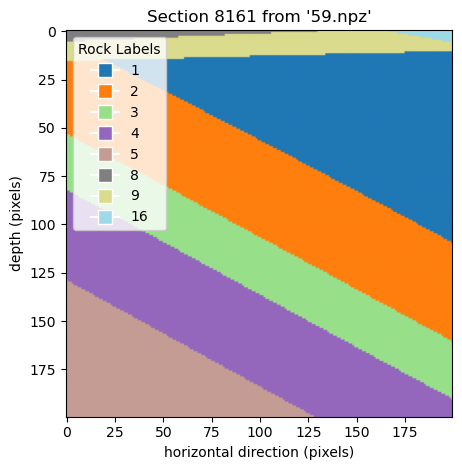

In [38]:
# Choose a random file
npz_idx: int = rd.randint(0, nbr_npz)
# Load the numpy array
multi_array: np.ndarray[np.int8] = np.load(dataset_path / f"{npz_idx}.npz", mmap_mode='r')["arr_0"]
# Choose a random section in this array
section_idx: int = rd.choice(range(len(multi_array)))
# Extract the section
section: np.ndarray[np.int8] = multi_array[section_idx]

# Plot the section
fig, ax = plt.subplots(1, 1)
class_color_map, norm, cmap_custom = create_colorbar(section)
sub_plot(ax, 0, section, f"Section {section_idx} from '{npz_idx}.npz'", class_color_map, cmap_custom, norm)
plt.tight_layout()
plt.show()

#### Random configuration
Number of electrodes, let it random or fix it.

In [39]:
# Choose a random number of electrodes 24 <= n <= 96
num_electrodes: int = rd.randint(24, 97)

Subsection to keep only a subsection of total_pixel_to_keep width will be kept. Let it random or fix it.

In [40]:
# Choose a random length of the subsection to keep num_electrodes - 1 <= n <= horizontal section length
total_pixels_to_keep: int = rd.randint(num_electrodes - 1, section.shape[1])
vertical_fraction: float = rd.uniform(0.5, 1.0) # 50% to 100% of the vertical section

Number of pixels between each electrodes (= number of cells in the mesh between each electrodes), the more the better, but the heavier the compute. 3 is a nice minimum, hit 4, 5 to be sure to have nice results, but memory and time might get you back to 3.

In [41]:
inter_electrode_num_pixels: int = 3

Lateral padding is also very important to have nice and precise result, we saw that 4-5 times the interelectrode space is a nice minimum, but again, time and memory make 3 a good candidate. Prefer a nice 3 for inter electrode spacing and 3 here than 2 and 4 or 4 and 2.

In [42]:
lateral_padding: int = 3
lateral_padding: int = inter_electrode_num_pixels * lateral_padding

So let's see the summary:

In [61]:
# This is the final horizontal section length we want
total_pixels_after_refinement: int = (num_electrodes - 1) * inter_electrode_num_pixels + 2 * lateral_padding

print(f"Number of electrodes: {num_electrodes}")
print(f"Subsection shape: {total_pixels_to_keep, int(total_pixels_to_keep * vertical_fraction)} (vertical fraction: {vertical_fraction})")
print(f"Number of pixels between each electrodes: {inter_electrode_num_pixels}")
print(f"Number of padding pixels on each side: {lateral_padding} (total: {2 * lateral_padding})")
print(f"\nTotal pixels after refinement: {total_pixels_after_refinement}")

Number of electrodes: 56
Subsection shape: (185, 93) (vertical fraction: 0.5042908721460235)
Number of pixels between each electrodes: 3
Number of padding pixels on each side: 9 (total: 18)

Total pixels after refinement: 183


We can then extract a random subsection from our section. You can also modify depth_slice and width_slice to extract a specific subsection.

Depth slice: slice(10, 110, None)
Width slice: slice(0, 185, None)


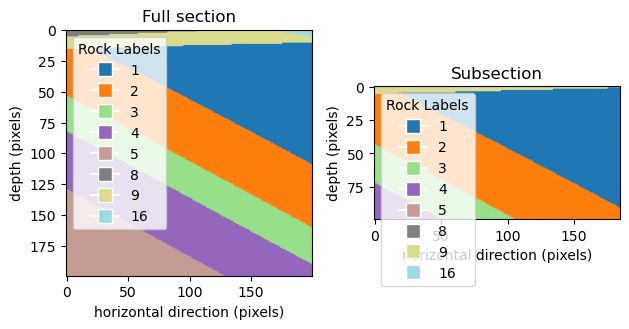

In [62]:
# Extract the subsection
sub_section, depth_slice, width_slice = extract_random_subsection(section, total_pixels_to_keep, vertical_fraction)

print(f"Depth slice: {depth_slice}")
print(f"Width slice: {width_slice}")

# Plot the section and the subsection
fig, ax = plt.subplots(1, 2)
class_color_map, norm, cmap_custom = create_colorbar(section)
titles: list[str] = [f"Full section", f"Subsection"]
for idx, (img, title) in enumerate(zip([section, sub_section], titles)):
    sub_plot(ax, idx, img, title, class_color_map, cmap_custom, norm)
plt.tight_layout()
plt.show()

And then, to ensure we have at least (in fact exactly) inter_electrode_num_pixels pixels between each electrodes, we resize the subsection. We make sure that the width/depth ratio is vertical_fraction.

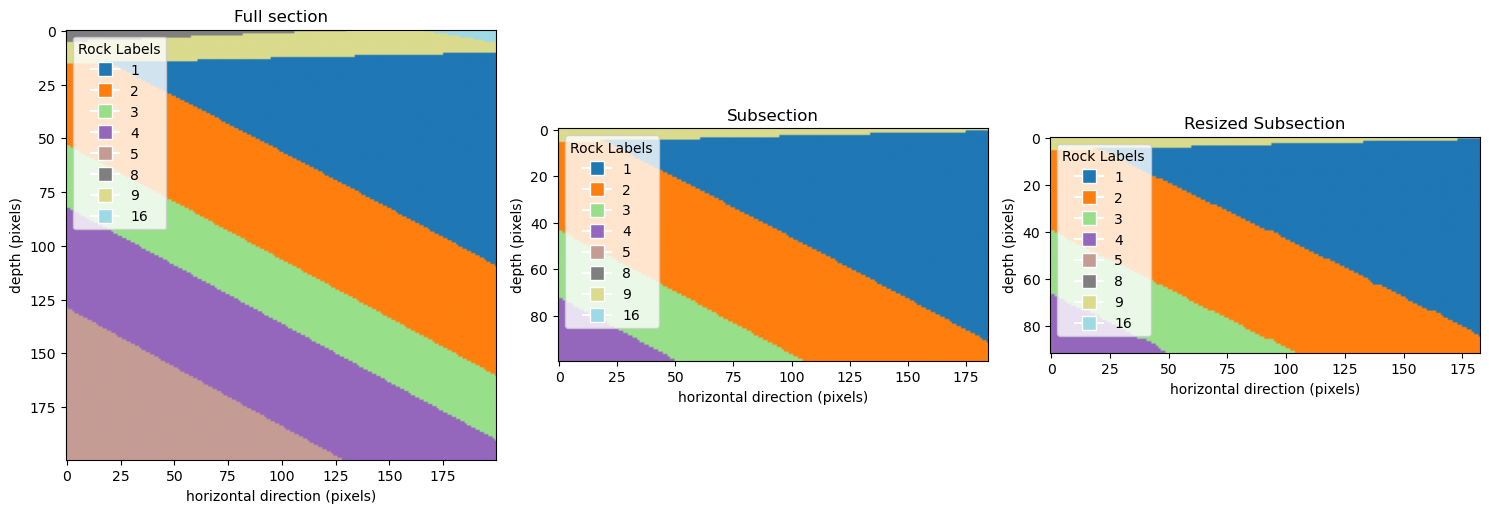

In [63]:
vertical_size: int = int(vertical_fraction * total_pixels_after_refinement)
# Resize the section
sub_section_resized: np.ndarray[np.int8] = resize(sub_section, (vertical_size, total_pixels_after_refinement))

# Plot the section, the subsection and the resized subsection
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
class_color_map, norm, cmap_custom = create_colorbar(section)
titles: list[str] = [f"Full section", f"Subsection", f"Resized Subsection"]
for idx, (img, title) in enumerate(zip([section, sub_section, sub_section_resized], titles)):
    sub_plot(axes, idx, img, title, class_color_map, cmap_custom, norm)
plt.tight_layout()
plt.show()

### Resistivity assignation
We assign each rock class a random resistivity. The resistivity value is sampled from a uniform distribution on $ \left[0, 1\right] $ and mapped using a logarithm function to $ \left[2, 20000\right] $.

In [64]:
# Extract the rock classes
rock_classes, inv = np.unique(sub_section_resized, return_inverse=True)
# Create a random normalized log resistivity value for each rock class
norm_log_res_values: np.ndarray[np.float64] = np.random.uniform(0, 1, size=len(rock_classes))
# Assign the random log resistivity value to each pixel according to its rock class
norm_log_resistivity_model: np.ndarray[np.float64] = norm_log_res_values[inv].reshape(sub_section_resized.shape)
# Detransform the resistivity values
resistivity_model: np.ndarray[np.float64] = detransform(norm_log_resistivity_model)

In [91]:
# Extract the rock classes
rock_classes, inv = np.unique(sub_section_resized, return_inverse=True)
norm_log_res_values: np.ndarray[np.float32] = np.random.uniform(0, np.log(50000), size=len(rock_classes)).astype(np.float32)
def custom_log_taper(logx):
    """
    Custom taper function based on ln(x):
      - 0 for x < 1
      - Ramp up to 1 from ln(1) to ln(10)
      - 1 from ln(10) to ln(2000)
      - Ramp down to 0 from ln(2000) to ln(50000)
    """
    logx = np.asarray(logx)
    y = np.zeros_like(logx)

    # Define log boundaries
    x_p_min_1 = np.log(1)
    x_p_max_1 = np.log(20)
    x_p_max_2 = np.log(2000)
    x_p_min_2 = np.log(50000)

    # Ramp up: x_p_min_1 to x_p_max_1
    ramp_up = (logx >= x_p_min_1) & (logx < x_p_max_1)
    y[ramp_up] = 0.5 * (1 - np.cos(np.pi * (logx[ramp_up] - x_p_min_1) / (x_p_max_1 - x_p_min_1)))

    # Plateau: x_p_max_1 to x_p_max_2
    plateau = (logx >= x_p_max_1) & (logx < x_p_max_2)
    y[plateau] = 1.0

    # Ramp down: x_p_max_2 to x_p_min_2
    ramp_down = (logx >= x_p_max_2) & (logx < x_p_min_2)
    y[ramp_down] = 0.5 * (1 + np.cos(np.pi * (logx[ramp_down] - x_p_max_2) / (x_p_min_2 - x_p_max_2)))

    return y

for idx in range(len(norm_log_res_values)):
    while np.random.uniform(0, 1) > custom_log_taper(norm_log_res_values[idx]):
        norm_log_res_values[idx] = np.random.uniform(0, np.log(50000))
    norm_log_res_values[idx] /= np.log(50000) # Normalize to [0, 1]
    np.log(50000)

print(norm_log_res_values)
norm_log_resistivity_model: np.ndarray[np.float64] = norm_log_res_values[inv].reshape(sub_section_resized.shape)
resistivity_model: np.ndarray[np.float64] = detransform(norm_log_resistivity_model)

[0.57411194 0.6251852  0.33095083 0.39139375 0.46772933]


Just plotting and printing the resistivities.

Rock class 1 with normalized log resistivity 0.5741119384765625 and resistivity 498.57991363545506 ohm.m
Rock class 2 with normalized log resistivity 0.6251851916313171 and resistivity 866.4159977563811 ohm.m
Rock class 3 with normalized log resistivity 0.3309508264064789 and resistivity 35.9027740738314 ohm.m
Rock class 4 with normalized log resistivity 0.3913937509059906 and resistivity 69.04742633704156 ohm.m
Rock class 9 with normalized log resistivity 0.4677293300628662 and resistivity 157.70522853980842 ohm.m


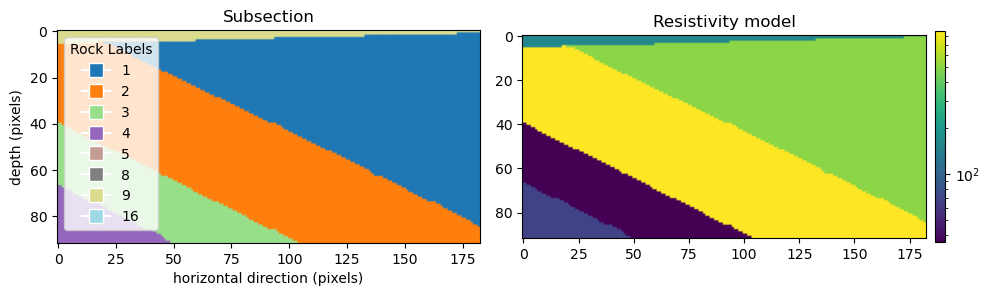

In [92]:
# Print the normalized log resistivity and the resistivity values
for rock_class, norm_log_res in zip(rock_classes, norm_log_res_values):
    print(f"Rock class {rock_class} with normalized log resistivity {norm_log_res} and resistivity {detransform(norm_log_res)} ohm.m")

# Plot the resized subsection and the resistivity model
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sub_plot(axes, 0, sub_section_resized, f"Subsection", class_color_map, cmap_custom, norm)
img = axes[1].imshow(resistivity_model, cmap="viridis", norm=mcolors.LogNorm())
axes[1].set_title(f"Resistivity model")
fig.colorbar(img, ax=axes[1], orientation='vertical', fraction=0.025, pad=0.02)
plt.tight_layout()
plt.show()

We need to flatten resistivity models to map it to the mesh. Additionnally, the axis of the mesh are flipped compared to the resistivity model. We also pass the resistivity model to log for numeric stability. /!\ This log is different from the norm_log_resitivity_model

In [93]:
resistivity_model_flat = np.flipud(resistivity_model).ravel()
norm_log_resistivity_model_flat = np.flipud(norm_log_resistivity_model).ravel()

### Topography

Topography is mandatory for simPEG, so let's create one (flat here).

In [94]:
# Create x coordinates
x_topo = np.linspace(lateral_padding, total_pixels_after_refinement - lateral_padding, total_pixels_after_refinement)
# We want a flat topography
z_topo = np.zeros_like(x_topo)
# Create the 2D topography
topo_2d = np.c_[x_topo, z_topo]

And plot it:

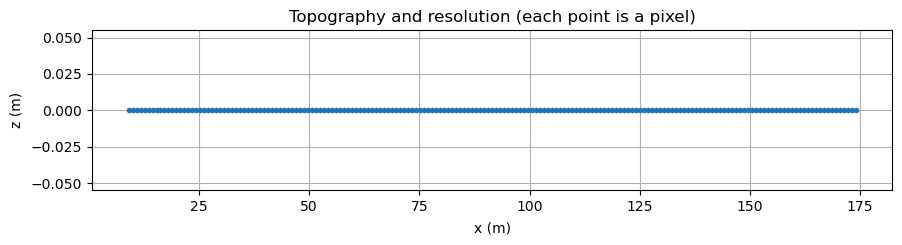

In [95]:
fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(x_topo, z_topo, marker=".")
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("z (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography and resolution (each point is a pixel)")
plt.show(fig)

### Arrays creation

Here we create the array. We use functions that set the coordinates of each sources, receivers.

In [96]:
# Define electrode locations, first electrode is at origin + lateral_padding, last electrode is at total_pixels_after_refinement - lateral_padding
electrode_locations_x = np.linspace(lateral_padding, total_pixels_after_refinement - lateral_padding, num_electrodes)
# The electrodes are on surface (z=0)
electrode_locations_z = np.zeros_like(electrode_locations_x)

electrode_locations = np.c_[electrode_locations_x, electrode_locations_z]

Array type : Wenner or Schlumberger. Let it random or fix it.

In [97]:
array = np.random.choice([schlumberger_array, wenner_array])
print(f"Array type: {array.__name__}")

Array type: schlumberger_array


In [98]:
source_list = array(num_electrodes, electrode_locations, "apparent_resistivity")

# Define survey
survey = dc.Survey(source_list)

### Mesh creation

simPEG uses discretize Mesh class. 

In [99]:
# Specify the length and the number of cells in the horizontal direction
hx = [(1, total_pixels_after_refinement)]
# Specify the length and the number of cells in the vertical direction
hz = [(1, vertical_size)]

# Create the tensor mesh, origin is at the top left corner
mesh = TensorMesh((hx, hz), origin="0N")

print(f"Number of cells for TensorMesh: {mesh.n_cells}")

Number of cells for TensorMesh: 16836


We can then plot the mesh. There might be aliasing, and checkerboard patterns but I think they come from roundings.

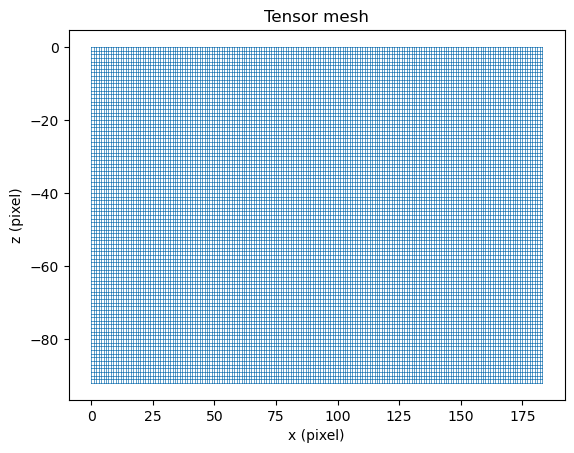

In [100]:
mesh.plot_grid(linewidth=0.5)
plt.title("Tensor mesh")
plt.xlabel("x (pixel)")
plt.ylabel("z (pixel)")
plt.grid(False)
plt.show()

Here we just add the electrodes on the mesh, electrodes should be on nodes.

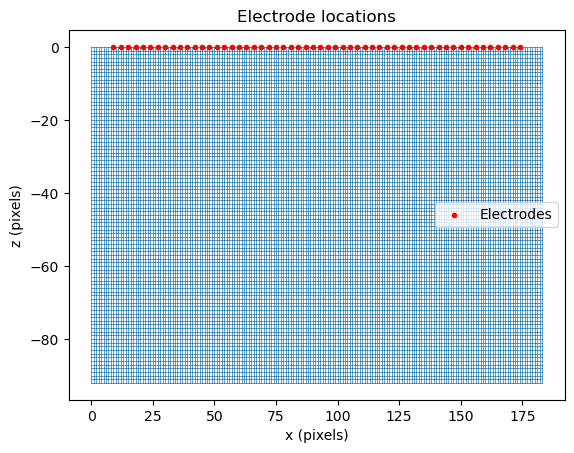

In [101]:
mesh.plot_grid(linewidth=0.5)
plt.scatter(electrode_locations_x, electrode_locations_z, marker='.', color='red', label='Electrodes', zorder=10)
plt.xlabel("x (pixels)")
plt.ylabel("z (pixels)")
plt.title("Electrode locations")
plt.legend(loc="center right")
plt.grid(False)
plt.show()

Now we active every cell as they all participate to the modelling.

In [102]:
# We activate all cells below the surface
active_cells = active_from_xyz(mesh, topo_2d)

To map resistivity model to mesh, we need to use an IdentityMap. As we use log resistivity model, the map uses ExpMap.

In [103]:
resistivity_map = maps.IdentityMap(mesh)

### Plot the mesh, the resistivity model and the electrodes

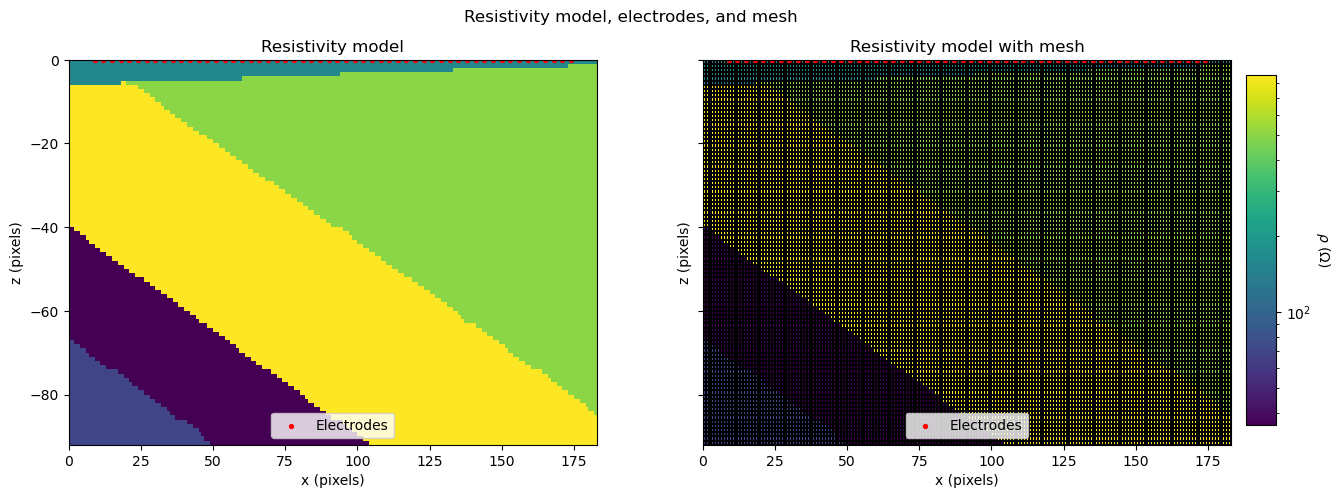

In [104]:
# Plot the resistivity model on the mesh
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

norm = LogNorm(vmin=np.min(resistivity_model_flat), vmax=np.max(resistivity_model_flat))
mesh_plot = mesh.plot_image(resistivity_map * resistivity_model_flat, ax=axes[0], grid=True)
for grid_line in mesh_plot:
    grid_line.set_linewidth(0.)  # Disable the grid lines
mesh_plot[0].set_norm(norm)
axes[0].set_title("Resistivity model")
axes[0].scatter(electrode_locations_x, electrode_locations_z, 8, "r", label="Electrodes")
axes[0].set_xlabel("x (pixels)")
axes[0].set_ylabel("z (pixels)")
axes[0].legend(loc="lower center")

mesh_plot = mesh.plot_image(resistivity_map * resistivity_model_flat, ax=axes[1], grid=True)
for grid_line in mesh_plot:
    grid_line.set_linewidth(0.1)  # Here we see the mesh grid
mesh_plot[0].set_norm(norm)
axes[1].set_title("Resistivity model with mesh")
axes[1].scatter(electrode_locations_x, electrode_locations_z, 8, "r", label="Electrodes")
axes[1].set_xlabel("x (pixels)")
axes[1].set_ylabel("z (pixels)")
axes[1].legend(loc="lower center")

# Add a shared colorbar between both subplots
cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])  # Position for the colorbar
cbar = fig.colorbar(axes[1].collections[0], cax=cbar_ax, norm=norm)
cbar.set_label(r"$\rho$ ($\Omega$)", rotation=270, labelpad=15)

plt.suptitle("Resistivity model, electrodes, and mesh")

plt.show()

We ensure electrodes are on the mesh and compute the geometric factors.

In [105]:
survey.drape_electrodes_on_topography(mesh, active_cells, option="top", topography=topo_2d)
_ = survey.set_geometric_factor()

This is the simulation object. mesh, survey, rhoMap are mandatory here.

Here are the options:
- nky=11, the number of wave number (ky) used for the numerical integration in the 2.5D Fourier/Hankel transform. Higher is more accurate but means solving the PDE problem nky times.
- storeJ=False, mainly interesting if you use J several times, which is not our case when generating the dataset, but which is the case here.
- miniaturize=False, only developped for pole pole survey types. Not our case.
- do_trap=False, if True, use the trapezoidal rule with logarithmically spaced wavenumber points. Less accurate, so let's try not using it.
- fix_Jmatrix=False, not clear.
- surface_faces=None, to specify the boundaries. Our case is simple and will be handle.
- solver=None, to specify the solver. If available use Pardiso, if not, use SolverLU.
- solver_opts=None, arguments to pass to the solver.
- verbose=False, you can set it True to see some of the steps.

About the solvers:
- SolverLU has these options:
  - accuracy_tol (Float): tolerance on the accuracy of the solver, a float, Default: 1e-06
  - check_accuracy (Boolean): check the accuracy of the solve?, a boolean, Default: False
- Pardiso doesn't seem to have options to pass with solver_opts



In [106]:
resistivity_simulation = dc.simulation_2d.Simulation2DNodal(mesh=mesh, survey=survey, rhoMap=resistivity_map, nky=5, verbose=True)

optimized ks converged? : True
Estimated transform Error: 0.0012668188549105062


## Forward step

### Compute fields

In [107]:
start = perf_counter()
fields = resistivity_simulation.fields(resistivity_model_flat)
end = perf_counter()
print(f"Mesh fields computation time: {end - start:.3f} s")

>> Compute fields


/root/miniconda3/envs/simPEG/lib/python3.13/site-packages/simpeg/electromagnetics/static/resistivity/simulation_2d.py:756: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
/root/miniconda3/envs/simPEG/lib/python3.13/site-packages/simpeg/electromagnetics/static/resistivity/simulation_2d.py:783: RuntimeWarning: invalid value encountered in divide
  alpha[not_top] = (ky * k1e(ky * r) / k0e(ky * r) * r_dot_n)[not_top]
/root/miniconda3/envs/simPEG/lib/python3.13/site-packages/simpeg/simulation.py:197: DefaultSolverWarning: Using the default solver: Pardiso. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)


KeyboardInterrupt: 

In [ ]:
start_time = perf_counter()
forward_model = resistivity_simulation.dpred(resistivity_model_flat, fields)
stop_time = perf_counter()
print(f"Mesh resistivity prediciton time: {stop_time - start_time:.3f} s")

Mesh resistivity prediciton time: 0.217 s


In [ ]:
start_time = perf_counter()
sensitivity_matrix = resistivity_simulation.getJ(resistivity_model_flat, fields)
stop_time = perf_counter()
print(f"Mesh sensitivity matrix computation time: {stop_time - start_time:.3f} s")

Calculating J and storing


/root/miniconda3/envs/simPEG/lib/python3.13/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


Mesh sensitivity matrix computation time: 2.566 s


In [ ]:
if array == wenner_array:
    process_pseudo_section = process_pseudo_section_wenner_array
else:
    process_pseudo_section = process_pseudo_section_schlumberger_array

Let's store the L2 norm contribution of each pixel of the resistivity model.

In [ ]:
L2_contribution = np.sqrt(np.sum(np.square(sensitivity_matrix), axis=0))

# Some reshaping to visualize
L2_contribution = np.flipud(L2_contribution.reshape(resistivity_model.shape))
print(f"Total contribution: {L2_contribution.sum():.3f}")

Total contribution: 170.505


And let's store the L2 norm dependance of each pixel of the pseudosection

In [ ]:
L2_dependance = np.sqrt(np.sum(np.square(sensitivity_matrix), axis=1))
print(f"Total dependance: {L2_dependance.sum():.3f}")

# Some reshaping to visualize
L2_dependance = process_pseudo_section(L2_dependance, num_electrodes)

Total dependance: 246.997


### Results visualisation

Just defining the process_pseudo_section function.

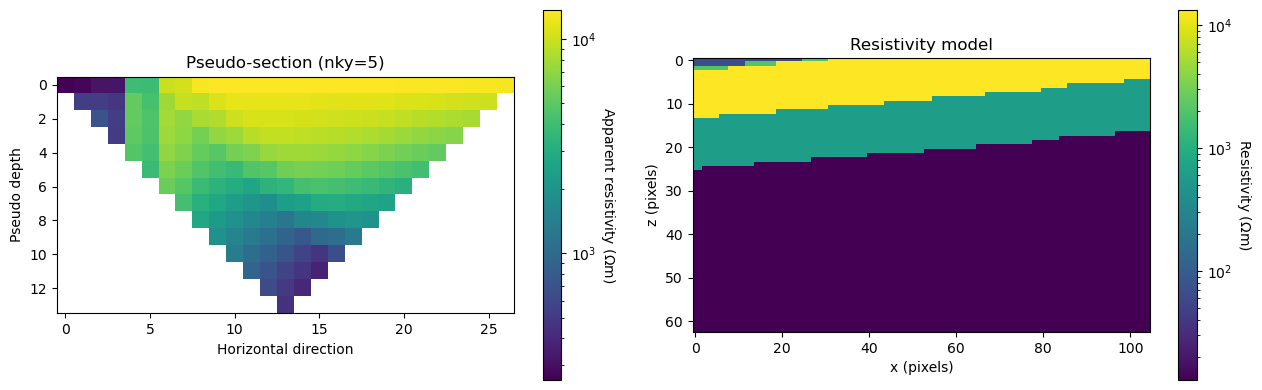

In [ ]:
pseudo_section = process_pseudo_section(forward_model, num_electrodes)

fig, axes = plt.subplots(1, 2, figsize=(13, 4))
vmin = np.nanmin(pseudo_section)
vmax = np.nanmax(pseudo_section)
norm = LogNorm(vmin=vmin, vmax=vmax)
im0 = axes[0].imshow(pseudo_section, cmap="viridis", norm=norm)
axes[0].set_title("Pseudo-section (nky=5)")
axes[0].set_ylabel("Pseudo depth")
axes[0].set_xlabel("Horizontal direction")
cbar0 = fig.colorbar(im0, ax=axes[0])
cbar0.set_label(r"Apparent resistivity ($\Omega$m)", rotation=270, labelpad=15)

vmin = np.min(resistivity_model)
vmax = np.max(resistivity_model)
norm = LogNorm(vmin=vmin, vmax=vmax)
im1 = axes[1].imshow(resistivity_model, cmap="viridis", norm=norm)
axes[1].set_title("Resistivity model")
axes[1].set_ylabel("z (pixels)")
axes[1].set_xlabel("x (pixels)")
cbar1 = fig.colorbar(im1, ax=axes[1])
cbar1.set_label(r"Resistivity ($\Omega$m)", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

Let's see which pixels contributed the most to the pseudosection.

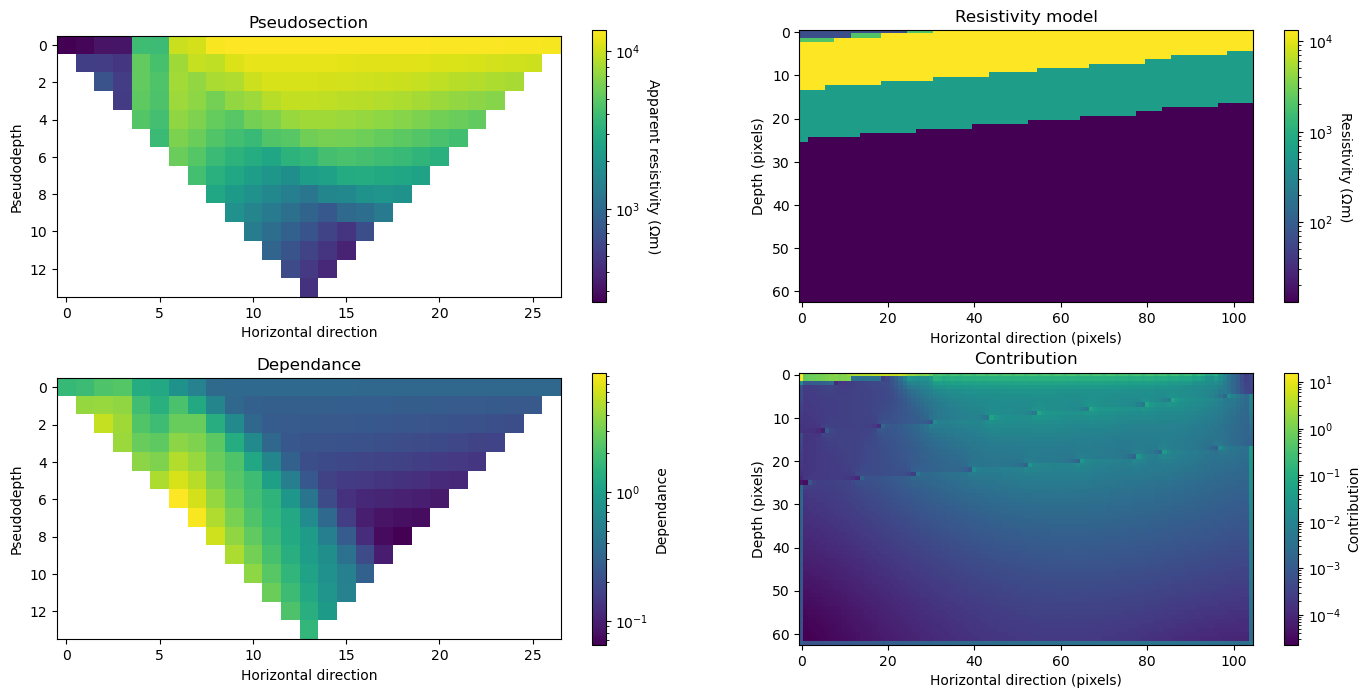

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 7))

vmin = np.nanmin(pseudo_section)
vmax = np.nanmax(pseudo_section)
norm = LogNorm(vmin=vmin, vmax=vmax)
im0 = axes[0, 0].imshow(pseudo_section, cmap="viridis", norm=norm)
axes[0, 0].set_title("Pseudosection")
axes[0, 0].set_ylabel("Pseudodepth")
axes[0, 0].set_xlabel("Horizontal direction")
cbar0 = fig.colorbar(im0, ax=axes[0, 0])
cbar0.set_label(r"Apparent resistivity ($\Omega$m)", rotation=270, labelpad=15)

vmin = np.min(resistivity_model)
vmax = np.max(resistivity_model)
norm = LogNorm(vmin=vmin, vmax=vmax)
im1 = axes[0, 1].imshow(resistivity_model, cmap="viridis", norm=norm)
axes[0, 1].set_title("Resistivity model")
axes[0, 1].set_ylabel("Depth (pixels)")
axes[0, 1].set_xlabel("Horizontal direction (pixels)")
cbar1 = fig.colorbar(im1, ax=axes[0, 1])
cbar1.set_label(r"Resistivity ($\Omega$m)", rotation=270, labelpad=15)

vmin = np.nanmin(L2_dependance)
vmax = np.nanmax(L2_dependance)
norm = LogNorm(vmin=vmin, vmax=vmax)
im2 = axes[1, 0].imshow(L2_dependance, cmap="viridis", norm=norm)
axes[1, 0].set_title("Dependance")
axes[1, 0].set_ylabel("Pseudodepth")
axes[1, 0].set_xlabel("Horizontal direction")
cbar2 = fig.colorbar(im2, ax=axes[1, 0])
cbar2.set_label("Dependance")

vmin = np.min(L2_contribution)
vmax = np.max(L2_contribution)
norm = LogNorm(vmin=vmin, vmax=vmax)
im3 = axes[1, 1].imshow(L2_contribution, cmap="viridis", norm=norm)
axes[1, 1].set_title("Contribution")
axes[1, 1].set_ylabel("Depth (pixels)")
axes[1, 1].set_xlabel("Horizontal direction (pixels)")
cbar3 = fig.colorbar(im3, ax=axes[1, 1])
cbar3.set_label("Contribution")


plt.tight_layout()
plt.show()

As contribution score value range is extremely extended, the following plot allows to set a threshold to see details. Set to -1 to set it by default.

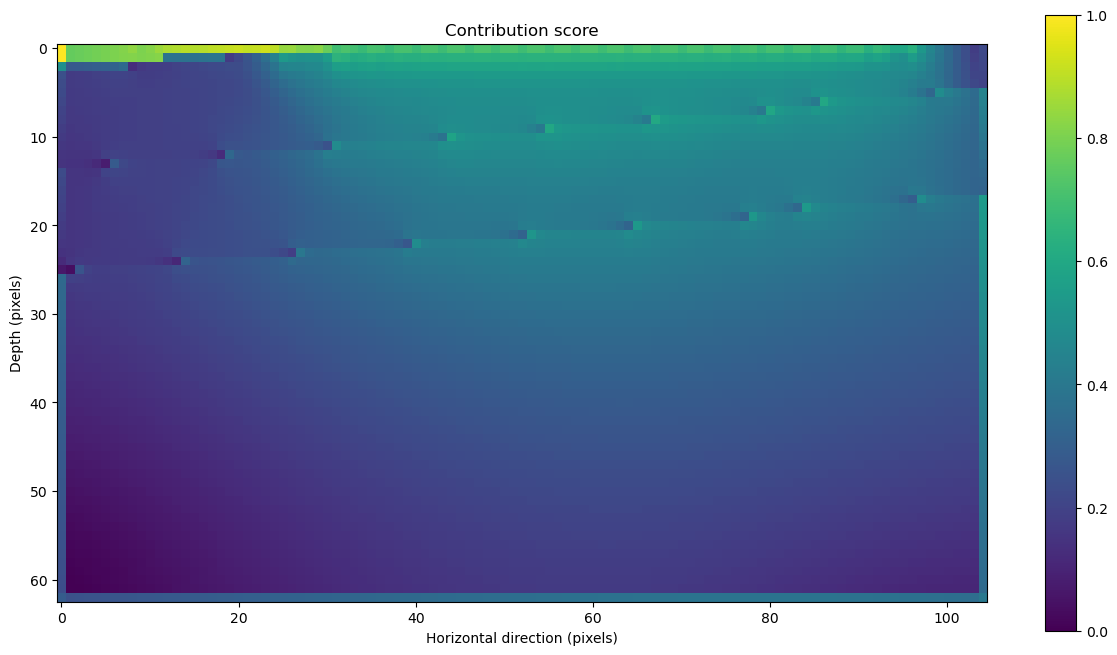

In [ ]:
L2_contribution = np.sum(np.square(sensitivity_matrix), axis=0)

# Some reshaping to visualize
L2_contribution = np.flipud(L2_contribution.reshape(resistivity_model.shape))


L2_contribution = np.log(L2_contribution)
L2_contribution = (L2_contribution - np.min(L2_contribution)) / (np.max(L2_contribution) - np.min(L2_contribution))


min_threshold = -1
max_threshold = -1

if min_threshold < 0:
    min_threshold = np.min(L2_contribution)
if max_threshold < 0:
    max_threshold = np.max(L2_contribution)

norm = Normalize(vmin=min_threshold, vmax=max_threshold)
plt.figure(figsize=(15, 8))
plt.imshow(L2_contribution, cmap="viridis", norm=norm)
plt.title("Contribution score")
plt.colorbar()
plt.xlabel("Horizontal direction (pixels)")
plt.ylabel("Depth (pixels)")
plt.show()

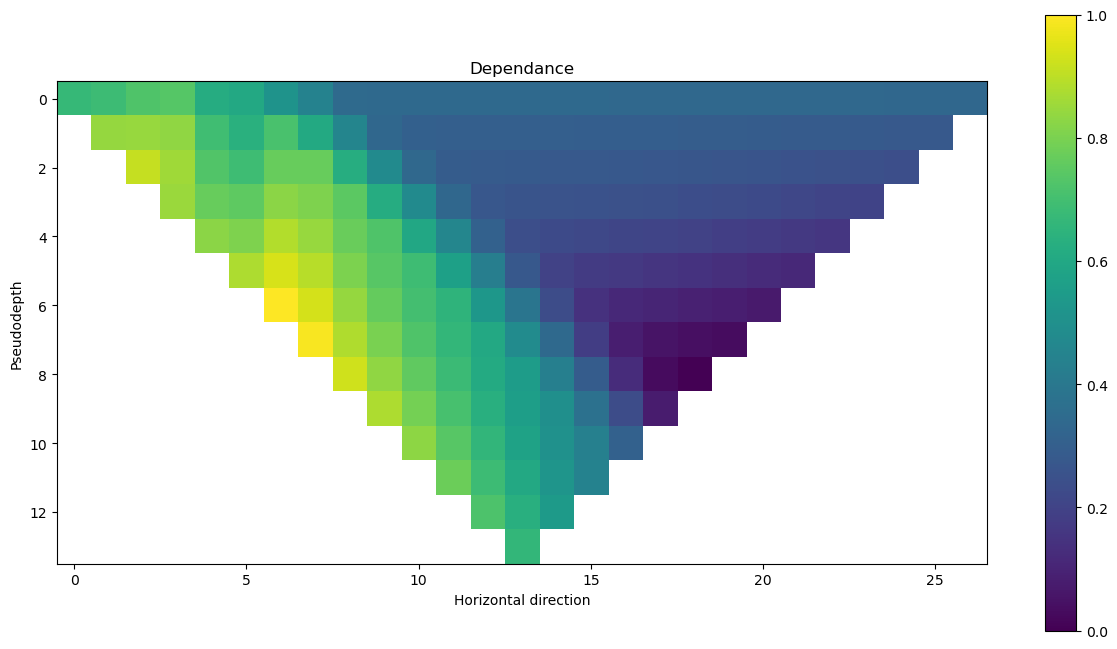

In [ ]:
L2_dependance = np.sum(np.square(sensitivity_matrix), axis=1)
# Some reshaping to visualize
L2_dependance = process_pseudo_section(L2_dependance, num_electrodes)
L2_dependance = np.log(L2_dependance)
L2_dependance = (L2_dependance - np.nanmin(L2_dependance)) / (np.nanmax(L2_dependance) - np.nanmin(L2_dependance))

min_threshold = -1
max_threshold = -1

if min_threshold < 0:
    min_threshold = np.nanmin(L2_dependance)
if max_threshold < 0:
    max_threshold = np.nanmax(L2_dependance)


norm = Normalize(vmin=min_threshold, vmax=max_threshold)
plt.figure(figsize=(15, 8))
plt.imshow(L2_dependance, cmap="viridis", norm=norm)
plt.title("Dependance")
plt.colorbar()
plt.xlabel("Horizontal direction")
plt.ylabel("Pseudodepth")
plt.show()